In [12]:
import os
import numpy as np

from hmmlearn import hmm
from scipy.io import wavfile
from python_speech_features import mfcc
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy.stats import multivariate_normal


In [13]:
TRAIN_DIR = "Data/isolated_digits_ti_train_endpt"
TEST_DIR = "Data/isolated_digits_ti_test_endpt"

NUM_CEP = 13  # parameter for MFCC
NUM_LABELS = 11  # 1, 2, 3, 4, ...
PRINT_FREQ = 500
NUM_MODELS = 2 # no of Gaussians in GMM (k)

### FFT for sample audio

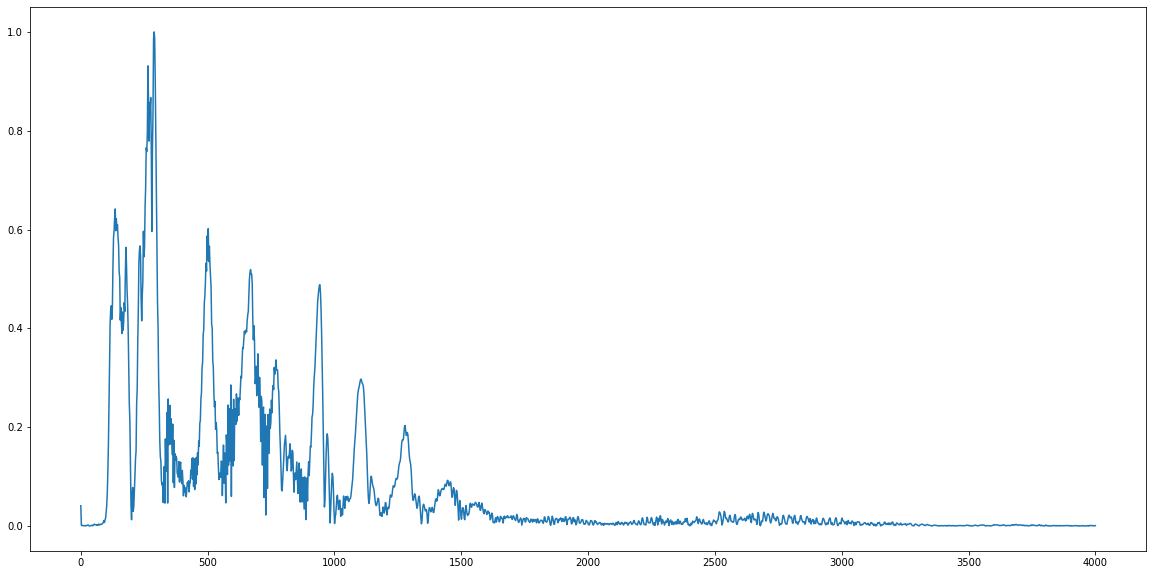

In [14]:
file_path = "Data/isolated_digits_ti_train_endpt/MAN/AE/1A_endpt.wav"
sampling_freq, audio = wavfile.read(file_path)

N = len(audio)

T = 1.0 / sampling_freq
freq = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

ampl_fft = scipy.fftpack.fft(audio)
ampl_fft = np.abs(ampl_fft[:N//2].reshape(int(N/2),1))
ampl_fft /= np.max(ampl_fft)

plt.figure(figsize=(20,10))
plt.plot(freq, ampl_fft)
plt.show()


### Calculate frequencies samples according to FFT amplidude for a given frequency

In [15]:
size_factor = 1000

freq_samples = np.array([])
for i, f in enumerate(freq):
    freq_samples = np.concatenate((freq_samples, [f] * int(ampl_fft[i,0]*size_factor)))

### GMM class with methods for EM algorithm 

In [21]:

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)

        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)

    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T,
                aweights=(weight/total_weight).flatten(),
                bias=True)

    def fit(self, X):
        self.initialize(X)

        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)

    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i],
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)

        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights

    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

    def get_features(self) -> np.ndarray:
        features = np.ndarray([])
        features = np.concatenate(features, np.array(self.mu))
        features = np.concatenate(features, np.array(self.sigma[0])) # TODO remove hardcode

        return features


### Fit GMM to a given audio

In [17]:
gmm = GMM(k=NUM_MODELS, max_iter=100)
gmm.fit(freq_samples.reshape(freq_samples.shape[0],1))

### Plot results

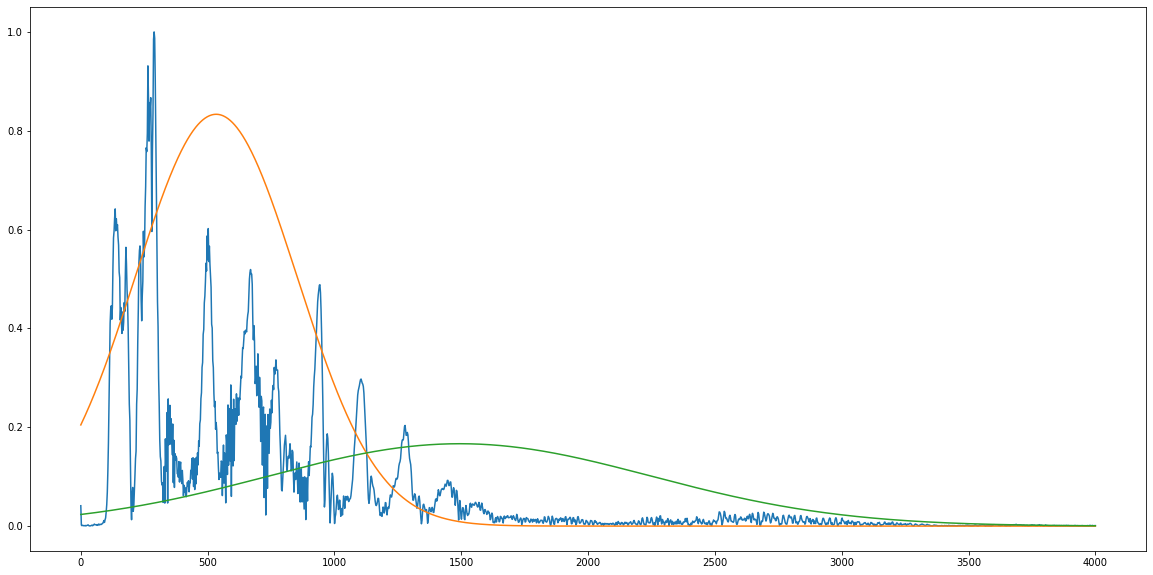

In [20]:
distributions = []
for i in range(NUM_MODELS):
    distributions.append(multivariate_normal(
        mean=gmm.mu[i],
        cov=gmm.sigma[i]))


plt.figure(figsize=(20,10))
plt.plot(freq, ampl_fft)

for i in range(NUM_MODELS):
    plt.plot(freq, gmm.phi[i] * distributions[i].pdf(freq) / max(distributions[i].pdf(freq))) # PDF functions normalized and weighted by phi - prior probability for a given Gaussian

In [ ]:
# Class to handle all HMM related processing
class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []

        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components,
                                         covariance_type=self.cov_type, n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')

    # X is a 2D numpy array where each row is 13D
    def train(self, X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))

    # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)


In [31]:
Label = str
Features = np.ndarray
FeaturesByLabelsDict = Dict[Label, Features]
ModelLabelTuple = Tuple[HMMTrainer, Label]
ModelsList = List[ModelLabelTuple]

def extract_label(file_name: str) -> str:
    return file_name[0]


def get_test_files() -> [str]:
    test_files: List[str] = []
    for gender_dir_name in os.listdir(TEST_DIR):
        # MAN, WOMAN
        gender_dir = os.path.join(TEST_DIR, gender_dir_name)
        if not os.path.isdir(gender_dir):
            continue

        for person_dir_name in os.listdir(gender_dir):
            # AH, AR, ...
            person_dir = os.path.join(gender_dir, person_dir_name)

            for file_name in [x for x in os.listdir(person_dir) if x.endswith('.wav')]:
                file = os.path.join(person_dir, file_name)
                test_files.append(file)
    return test_files

def obtain_gmm_features() -> FeaturesByLabelsDict:
    features_by_label: Dict[str, np.ndarray] = {}

    processed_files = 0
    for gender_dir_name in os.listdir(TRAIN_DIR):
        # MAN, WOMAN
        gender_dir = os.path.join(TRAIN_DIR, gender_dir_name)
        if not os.path.isdir(gender_dir):
            continue

        for person_dir_name in os.listdir(gender_dir):
            # AH, AR, ...
            person_dir = os.path.join(gender_dir, person_dir_name)

            for file_name in [x for x in os.listdir(person_dir) if x.endswith('.wav')]:

                label = extract_label(file_name)
                if label not in features_by_label:
                    features_by_label[label] = np.empty((0, NUM_CEP))

                file_path = os.path.join(person_dir, file_name)
                sampling_freq, audio = wavfile.read(file_path)

                # Extract MFCC features
                gmm = GMM(k=NUM_MODELS, max_iter=10)
                gmm.fit(freq_samples.reshape(freq_samples.shape[0],1))
                gmm_features = mfcc(audio, sampling_freq, numcep=NUM_CEP)

                features_by_label[label] = np.append(features_by_label[label], gmm_features, axis=0)
                processed_files += 1
                print(processed_files)
    return features_by_label

def obtain_mfcc_features() -> FeaturesByLabelsDict:
    mfcc_by_label: Dict[str, np.ndarray] = {}

    for gender_dir_name in os.listdir(TRAIN_DIR):
        # MAN, WOMAN
        gender_dir = os.path.join(TRAIN_DIR, gender_dir_name)
        if not os.path.isdir(gender_dir):
            continue

        for person_dir_name in os.listdir(gender_dir):
            # AH, AR, ...
            person_dir = os.path.join(gender_dir, person_dir_name)

            for file_name in [x for x in os.listdir(person_dir) if x.endswith('.wav')]:

                label = extract_label(file_name)
                if label not in mfcc_by_label:
                    mfcc_by_label[label] = np.empty((0, NUM_CEP))

                file_path = os.path.join(person_dir, file_name)
                sampling_freq, audio = wavfile.read(file_path)

                # Extract MFCC features
                mfcc_features = mfcc(audio, sampling_freq, numcep=NUM_CEP)

                mfcc_by_label[label] = np.append(mfcc_by_label[label], mfcc_features, axis=0)
    return mfcc_by_label


def train_hmm_models(data: FeaturesByLabelsDict) -> ModelsList:
    models: ModelsList = []
    for label, features in data.items():
        print('features of', label, 'shape =', features.shape)
        hmm_model = HMMTrainer()
        hmm_model.train(features)
        models.append((hmm_model, label))
    return models


def predict_label(models_list: ModelsList, features: Features) -> Label:
    max_score = -10_000
    best_label = None

    for item in models_list:
        hmm_model, label = item
        score = hmm_model.get_score(features)
        if score > max_score:
            max_score = score
            best_label = label
    return best_label

In [32]:
features_by_label = obtain_gmm_features()

KeyboardInterrupt: 

In [ ]:
# MFCC MODEL TRAINING
hmm_models = train_hmm_models(features_by_label)

In [ ]:
# MFCC MODEL TESTING
test_files = get_test_files()
no_files = len(test_files)
no_correct_pred = 0
for i, test_file in enumerate(test_files):
    sampling_freq, audio = wavfile.read(test_file)
    mfcc_features = mfcc(audio, sampling_freq)

    true_label = extract_label(test_file[test_file.rfind('/') + 1:])
    predicted_label = predict_label(hmm_models, mfcc_features)
    no_correct_pred += true_label == predicted_label

    if not i % PRINT_FREQ:
        print(f"File: {test_file}\nTrue label: {true_label}, predicted label: {predicted_label}\n")

print(f"Accuracy: {no_correct_pred / no_files}")